In [761]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim
from torch.autograd import Variable
import numpy.random as rand
import numpy as np
import sys
import os
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import



from bnn import BNNBayesbyBackprop, gauss_logpdf
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/d_berman/Documents/Tufts_Masters/Semester_3/Bayesian Deep Learning/BDL_final_project'

## Toy dataset for regression

In [762]:
W = np.array([-10, 10]).reshape(-1, 1)
b = -5
X_train = np.random.uniform(-10,10, (5000, 2))
X_train[:,0] = 0.0
X_train.shape
W.T.shape

eps = 0.0001
W_s = np.array([0.0, 0.3]).reshape(-1, 1)
print(W_s)
b_s = 0.1

print(b_s)

y_train = np.zeros((X_train.shape[0], 1), dtype=float)
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  y_train[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))



print(y_train)

[[0. ]
 [0.3]]
0.1
[[ 45.82018044]
 [ 11.11175376]
 [-41.48771775]
 ...
 [ 99.67947662]
 [-19.86093476]
 [ 13.68647673]]


(array([646., 635., 651., 657., 633., 703., 655., 337.,  77.,   6.]),
 array([-105.03859583,  -78.97820991,  -52.917824  ,  -26.85743808,
          -0.79705216,   25.26333376,   51.32371968,   77.38410559,
         103.44449151,  129.50487743,  155.56526335]),
 <a list of 10 Patch objects>)

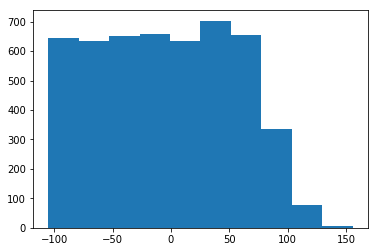

In [763]:
plt.hist(y_train)
# np.exp(10 * 0.01)

compare likelihood of test set given true mean and true variance and true variance + bias

In [4]:
tst = np.empty_like(X_train[:,0])
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  tst[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
tst

print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s)).sum())
print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s) + 100).sum())

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

Toy dataset for classification 2d

In [753]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
# X_train[:int(dataset_size/2),0] = np.random.normal(loc=0,
#                                                    scale=1,
#                                                    size=(int(dataset_size/2),))
# X_train[:int(dataset_size/2), 1] = np.random.normal(loc=0, 
#                                                     scale=1, 
#                                                     size=(int(dataset_size/2),))

scale = 1

X_train[:int(dataset_size/2), 0] = np.random.uniform(2 * scale, 12 * scale, 
                                                    size=(int(dataset_size/2),))
X_train[:int(dataset_size/2), 1] = np.random.uniform(7.5* scale, 13.5 * scale,
                                                   size=(int(dataset_size/2),))


y_train[:int(dataset_size/2)] = 0

X_train[int(dataset_size/2):,0] = np.random.uniform(2 * scale, 12 * scale,
                                                   size=(int(dataset_size/2),))
X_train[int(dataset_size/2):, 1] = np.random.uniform(0.5 * scale, 6.5 * scale,
                                                    size=(int(dataset_size/2),))
y_train[int(dataset_size/2):] = 1

# shuffle order
perm = np.random.permutation(dataset_size)
X_train = X_train[perm]
y_train = y_train[perm]

In [754]:
A = np.array([[1, 1],
              [1, 0]])
X_train = X_train @ A

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


sklearn logistic regression accuracy is: 1.0


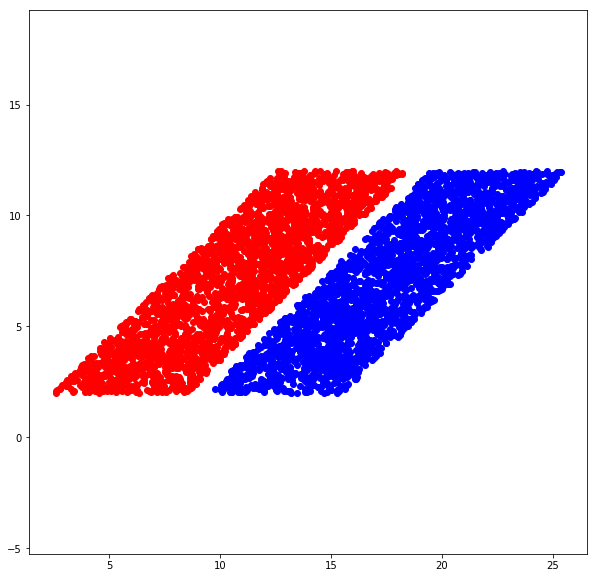

In [755]:
def plane(x1, x2, w1, b):
    return w1[0] * x1 + w1[1] * x2 + b
    

w1 = np.array([[0,0]]).T
w2 = np.array([[0,0]]).T
W_full = np.hstack((w1, w2))
b = 0

x = y = np.arange(-8.0, 8.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = plane(X, Y, w1, b)
# print("X shape", zs.shape)

# Z = zs.reshape(X.shape)

# ax.plot_surface(X, Y, Z)

# x_line = np.random.uniform(-8, 8, (100, 2))
#  = 
# print(w1.T.shape)
# y = w1.T @ x + b
# y = y.flatten()
# plt.plot(x1, x2)
# plt.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='red', alpha=0.2)
# plt.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='blue', alpha=0.2)
# plt.ylim((-10, 10))


fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(311, projection='3d')       
ax = fig.add_subplot(111)   

# ax.plot_wireframe(X, Y, zs, color='grey', alpha = 0.7)
ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='blue')
ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
ax.axis('equal')
# ax.set_ylim(-6, 6)
fig.show()
# print("------")                                                        
# print(x_line[:,0].shape)                                                   
# print(x_line[:,1].shape)                                                   
# print(y.shape)                                                        
# print("------")


# ax.scatter(X1_train_grd, X2_train_grd, alpha=0.5)

# ax.plot()
# ax.set_xlabel('X_train[:,0]')                                          
# ax.set_ylabel('X_train[:,1]')                                          
# ax.set_zlabel('output[:,1] (Standard Deviation)')                      
# fig.show()
# plt.show()

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('sklearn logistic regression accuracy is:', lr.score(X_train, y_train))

In [756]:
np.log(0.1)

-2.3025850929940455

In [757]:
for i, row_i in enumerate(X_train):
    X_train[i, 1] = X_train[i, 1] + np.random.normal(loc=0, scale= np.exp(0.08 * X_train[i, 0]))

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/Pytorch/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


sklearn logistic regression accuracy is: 0.8948


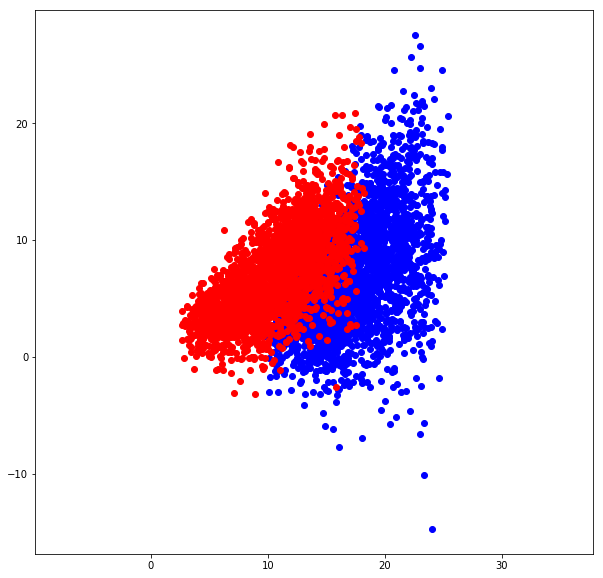

In [758]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('sklearn logistic regression accuracy is:', lr.score(X_train, y_train))

fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(311, projection='3d')       
ax = fig.add_subplot(111)   

# ax.plot_wireframe(X, Y, zs, color='grey', alpha = 0.7)
ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='blue')
ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
ax.axis('equal')
# ax.set_ylim(-6, 6)
fig.show()

Toy dataset for classification 1d

In [60]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
X_train[:int(dataset_size/2), 0] = 0
X_train[:int(dataset_size/2), 1] = np.random.normal(loc=2,
                                                 scale=1,
                                                 size=(int(dataset_size/2),))
y_train[:int(dataset_size/2)] = 0



X_train[int(dataset_size/2):, 0] = 0
X_train[int(dataset_size/2):, 1] = np.random.normal(loc=10,
                                                   scale=1,
                                                   size=(int(dataset_size/2),))
y_train[int(dataset_size/2):] = 1

# shuffle order
perm = np.random.permutation(dataset_size)
X_train = X_train[perm]
y_train = y_train[perm]

In [61]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.0

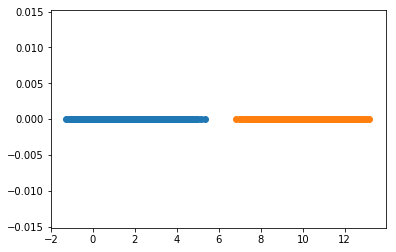

In [62]:
# a separating line!
# x1 = np.linspace(-2, 14, 20)
# y = x1 * 1 - 8.5

plt.scatter(X_train[y_train == 0, 1], [0]*int(X_train.shape[0]/2))
plt.scatter(X_train[y_train == 1, 1], [0]*int(X_train.shape[0]/2))
# plt.plot(x1, y)

In [ ]:
# W_full
# W
# preset_preds.shape
# print('MAE of BNN with q mean == true weights: ', np.mean(np.abs(preset_preds - y_train.flatten())))
# print('acc of BNN with q mean == true weights: ', np.mean((preset_preds == y_train.flatten()).astype(int)))
# print('\n')
# print(preset_preds[1], y_train[1])
# bnn_preset.model.l1.W_log_s_DO
# bnn_preset.model.l1.b_log_s_O
# bnn_preset.MC_elbo(torch.Tensor(X_train), torch.Tensor(y_train), 9, 10, 100).detach().numpy()

# plt.title("line with {} as slope".format(w))
# plt.plot(x1, x2)
# plt.scatter(X_train1[y_train1 == 0,0], X_train1[y_train1 == 0,1], c='red', alpha=0.2)
# plt.scatter(X_train1[y_train1 == 1,0], X_train1[y_train1 == 1,1], c='blue', alpha=0.2)
# plt.ylim((-10, 10))

# ax = fig.add_subplot(311, projection='3d')                             
# print("------")                                                        
# print(x1[:,0].shape)                                                   
# print(x1[:,1].shape)                                                   
# print(y1.shape)                                                        
# print("------")                                                        
# ax.plot_surface(x1[0,1], x1[:,1], y1)                                       
# ax.set_xlabel('X_train[:,0]')                                          
# ax.set_ylabel('X_train[:,1]')                                          
# ax.set_zlabel('output[:,1] (Standard Deviation)')                      
# fig.show()
# plt.show()



## test ELBO as slope of line changes

[[0. 0.]
 [1. 0.]]
[[0.]
 [1.]]
X_int 21.162403

used_b is -20.054132
used_w is  0.94763017

grads w1  tensor([-6.7961e-03, -6.9137e+03])
grad b  tensor(-695.3595)
Accuracy with -20 as bias:  50.0 %
likelihood -38209.665
X_int 20.216524

used_b is -18.58039
used_w is  0.9190695

grads w1  tensor([ 3.0592e-03, -1.0214e+04])
grad b  tensor(-1023.5146)
Accuracy with -19 as bias:  50.0 %
likelihood -37333.1875
X_int 16.733711

used_b is -17.609013
used_w is  1.0523076

grads w1  tensor([-8.2046e-03, -1.4813e+04])
grad b  tensor(-1454.5852)
Accuracy with -18 as bias:  50.0 %
likelihood -36397.1075
X_int 16.37387

used_b is -16.843601
used_w is  1.0286878

grads w1  tensor([ 2.8262e-03, -1.7274e+04])
grad b  tensor(-1709.2228)
Accuracy with -17 as bias:  50.0 %
likelihood -34417.4125
X_int 16.305536

used_b is -16.17023
used_w is  0.99170184

grads w1  tensor([-7.5810e-03, -2.3520e+04])
grad b  tensor(-2310.4102)
Accuracy with -16 as bias:  50.0 %
likelihood -33066.4475
X_int 17.553799

used

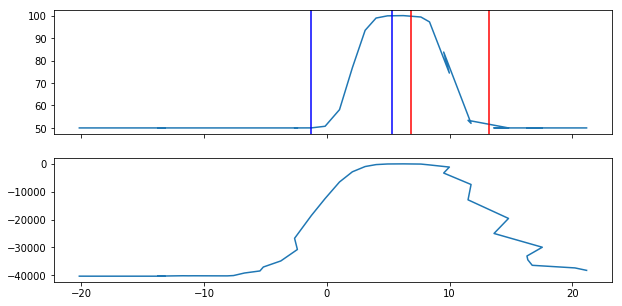

In [67]:
def plane(x1, x2, w1, b):
    return w1[0] * x1 + w1[1] * x2 + b

# for regression toy set
# W_full = np.hstack((W, W_s))
# W_full

# b_full = np.hstack((b, b_s))
# b_full[1] = 2.0

# for 3d
# w1 = np.array([[0.0,1.0]]).T
# w2 = np.array([[0.0,0.0]]).T
# W_full = np.hstack((w1, w2))

# x1 = x2 = np.arange(-8.0, 8.0, 0.05)
# X1, X2 = np.meshgrid(x, y)
# b = 0
# Z = plane(X1, X2, w1, b)


w1 = np.array([[0.0,1.0]]).T
w2 = np.array([[0.0,0.0]]).T
W_full = np.hstack((w1, w2))
print(W_full)
print(w1)
# x1 = x2 = np.arange(-8.0, 8.0, 0.05)
# X1, X2 = np.meshgrid(x, y)
# b = 0
# Z = plane(X1, X2, w1, b)
mc_samples = [i for 20 * i in range(1, 11)]
bs = [i for i in range(-20, 15)]
used_bs = []
accuracies = []
x_ints = []
likelihoods = []
grad_bs = []
for b in bs:
    b_full = np.array([b,0])
    # b_full[0], b_full[1] = 0,0
    bnn_preset = BNNBayesbyBackprop(prior_mu=0, 
                                    prior_s=0.8, 
                                    linear_regression=True, 
                                    classification=True,
                                    preset={'W_mu': W_full, 'b_mu': b_full},
                                    num_MC_samples=200)
    preset_preds = bnn_preset.model.forward(torch.Tensor(X_train), predict=True).detach().numpy()
    used_b = bnn_preset.model.l1.usedBias[0].detach().numpy()
    used_w = bnn_preset.model.l1.usedWeights[:,0][1].detach().numpy()
    used_bs.append(used_b)
    
    x_intercept = -used_b / used_w
    x_ints.append(x_intercept)
    print('X_int', x_intercept)
    print('\nused_b is', used_b)
    print('used_w is ', used_w)
    
    bnn_preset.MC_elbo(torch.Tensor(X_train), torch.Tensor(y_train), 9, 10, 100).detach().numpy()
    acc = np.mean((preset_preds == y_train.flatten()).astype(int)) * 100
    accuracies.append(acc)
    print('Accuracy with {} as bias: '.format(b), acc, '%')
    
    likelihood = bnn_preset.mean_likelihood
    likelihoods.append(likelihood)
    print('likelihood', likelihood)
    
    grad_bs.append(bnn_preset.gradB)
 
fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True)
ax[0].plot(x_ints, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')

# ax[0].scatter([np.min(X_train[y_train == 1, 1]), np.max(X_train[y_train == 1, 1])], [50,50], c='red')


ax[1].plot(x_ints, likelihoods)
print('class 0 min: ', np.min(X_train[y_train == 0, 1]))
print('class 0 max: ',np.max(X_train[y_train == 0, 1]))
print('class 1 min: ', np.min(X_train[y_train == 1, 1]))
print('class 1 max: ',np.max(X_train[y_train == 1, 1]))



In [ ]:
# nesting subplots in subplots for MC sampling model selection?

fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(3, 3, wspace=0.2, hspace=0.2)

for i in range(9):
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
    
    for j in range(3):
        ax = plt.Subplot(fig, inner[j])
#         t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i,j))
#         t.set_ha('center')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
        
fig.show()

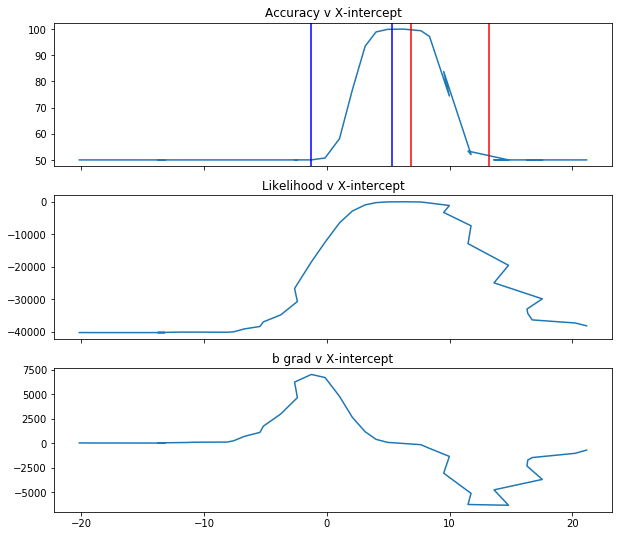

In [68]:


fig, ax = plt.subplots(3, 1, figsize=(10,9), sharex=True)
ax[0].set_title('Accuracy v X-intercept')
ax[0].plot(x_ints, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')
ax[1].set_title('Likelihood v X-intercept')
ax[1].plot(x_ints, likelihoods)

ax[2].set_title('b grad v X-intercept')
ax[2].plot(x_ints, grad_bs)

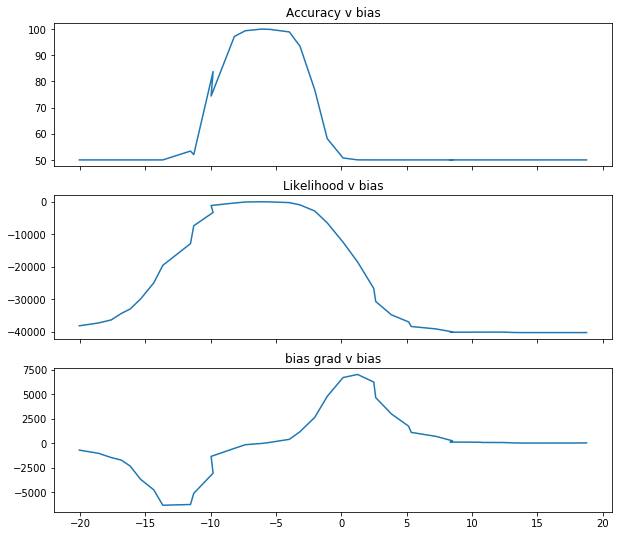

In [70]:
fig, ax = plt.subplots(3, 1, figsize=(10,9), sharex=True)
ax[0].set_title('Accuracy v bias')
ax[0].plot(used_bs, accuracies)
# ax[0].scatter([np.min(X_train[y_train == 0, 1]), np.max(X_train[y_train == 0, 1])], [50,50], c='blue')
# ax[0].axvline(np.min(X_train[y_train == 0, 1]), c='blue')
# ax[0].axvline(np.max(X_train[y_train == 0, 1]), c='blue')

# ax[0].axvline(np.min(X_train[y_train == 1, 1]), c='red')
# ax[0].axvline(np.max(X_train[y_train == 1, 1]), c='red')
ax[1].set_title('Likelihood v bias')
ax[1].plot(used_bs, likelihoods)

ax[2].set_title('bias grad v bias')
ax[2].plot(used_bs, grad_bs)

In [628]:
X_train1 = X_train
y_train1 = y_train

accuracies = []
weights = [0.0, 0.1, 0.5, 1.0, 3.0, 5.0, 5.5, 6.0, 7.0, 10.0]
for w in weights:
#     w1 = np.array([0, w])
    W_full[0][0] = w
    print('weights: ', W_full[0])
    bnn_preset = BNNBayesbyBackprop(prior_mu=0, 
                                prior_s=0.8, 
                                linear_regression=True, 
                                classification=True,
                                preset={'W_mu': W_full, 'b_mu': b_full})
    preset_preds = bnn_preset.model.forward(torch.Tensor(X_train1), predict=True).detach().numpy()
    print('ELBO components with {} as slope: \n'.format(w))
    bnn_preset.MC_elbo(torch.Tensor(X_train1), torch.Tensor(y_train1), 9, 10, 100).detach().numpy()
    print('Accuracy with {} as slope: '.format(w), np.mean((preset_preds == y_train1.flatten()).astype(int)) * 100, '%')
    
    Z = plane(X1, X2, W_full[0], b)
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(311, projection='3d') 
    ax.set_title("line with {} as slope".format(w))

    ax.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], c='blue')
    ax.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], c='red')
    ax.plot_wireframe(X1, X2, Z, color='grey', alpha = 0.99)

#     fig.show()
    plt.show()
#     x1 = np.random.uniform(-8, 8, 100)
#     x2 = w * x1

#     plt.title("line with {} as slope".format(w))
#     plt.plot(x1, x2)
#     plt.scatter(X_train1[y_train1 == 0,0], X_train1[y_train1 == 0,1], c='red', alpha=0.2)
#     plt.scatter(X_train1[y_train1 == 1,0], X_train1[y_train1 == 1,1], c='blue', alpha=0.2)
#     plt.ylim((-10, 10))
    

weights:  [0 0]
ELBO components with 0.0 as slope: 



IndexError: too many indices for tensor of dimension 1

In [ ]:
# bnn = BNNBayesbyBackprop(prior_mu=0, prior_s=0.8, num_MC_samples=30, linear_regression=True, preset=False, classification=False)
# w1 = np.array([[0.0, 1.0]]).T
# w2 = np.array([[0.0, 0.0]]).T
# W_full = np.hstack((w1, w2))
# b_full = np.array([0,0])
# print(W_full)

# 3865044.5 
bnn = BNNBayesbyBackprop(prior_mu=0.0, prior_s=1.0, num_MC_samples=100, linear_regression=False, preset=False, classification=False)

# bnn = BNNBayesbyBackprop(prior_mu=0.0, prior_s=1.0, num_MC_samples=100, linear_regression=True, preset=False, classification=True)
bnn.fit(X_train, y_train, plot=True, n_epochs=1200, learning_rate=1.5e-1, batch_size=1000)


Data being saved in following file:
logging.csv
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_prior:  -112.8879296875 	log_posterior: -124.096708984375 	likelihood:  -180027105.28 	reg:  -2302.5821875
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
l

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_prior:  -112.01134765625 	log_posterior: -123.72828125 	likelihood:  -175463014.4 	reg:  -2302.5821875
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_prior:  -117.4737890625 	log_posterior: -124.436240234375 	likelihood:  -162576107.52 	reg:  -2302.5821875
Epoch:  1 	Loss:  836786560.0 	MAE:  48.1352 	b:  -0.6922566 	W: -0.36798477
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.3025851
log_s_N max	 -2.3025851
log_s_N min	 -2.

log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -2.13802
log_s_N max	 1.609438
log_s_N min	 -4.243108
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -3.830834
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -1.2602789
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.6051702
log_s_N max	 1.609438
log_s_N min	 -4.

log_s_N max	 1.609438
log_s_N min	 1.0927775
log_s_N max	 1.609438
log_s_N min	 -2.729876
log_s_N max	 1.609438
log_s_N min	 1.0655792
log_s_N max	 1.4214332
log_s_N min	 0.5625854
log_s_N max	 1.609438
log_s_N min	 0.6687246
log_s_N max	 1.5424286
log_s_N min	 0.59719586
log_s_N max	 0.97372806
log_s_N min	 0.68387556
log_s_N max	 0.77425516
log_s_N min	 -0.20817128
log_s_N max	 1.609438
log_s_N min	 -1.9990108
log_s_N max	 1.609438
log_s_N min	 0.864358
log_s_N max	 1.609438
log_s_N min	 -0.7553131
log_s_N max	 1.609438
log_s_N min	 -0.79210085
log_s_N max	 1.5102217
log_s_N min	 -1.2125123
log_s_N max	 0.61041796
log_s_N min	 -0.005774766
log_s_N max	 1.609438
log_s_N min	 0.06118682
log_s_N max	 1.1949391
log_s_N min	 -0.152883
log_s_N max	 1.609438
log_s_N min	 -1.0224676
log_s_N max	 1.609438
log_s_N min	 -0.5727093
log_s_N max	 1.609438
log_s_N min	 -0.7455398
log_s_N max	 1.3721077
log_s_N min	 -0.03755027
log_s_N max	 1.1119249
log_s_N min	 0.03583187
log_s_N max	 1.609438
log

log_s_N max	 1.609438
log_s_N min	 0.5317371
log_s_N max	 1.609438
log_s_N min	 0.29829505
log_s_N max	 1.609438
log_s_N min	 0.77299124
log_s_N max	 1.609438
log_s_N min	 0.16518512
log_s_N max	 1.609438
log_s_N min	 -0.07061648
log_s_N max	 1.609438
log_s_N min	 0.48305398
log_s_N max	 1.609438
log_s_N min	 -0.38319808
log_s_N max	 1.609438
log_s_N min	 0.38838518
log_s_N max	 1.609438
log_s_N min	 0.25069493
log_s_N max	 1.609438
log_s_N min	 0.22202688
log_s_N max	 1.609438
log_s_N min	 1.0330088
log_s_N max	 1.609438
log_s_N min	 -0.32980454
log_s_N max	 1.609438
log_s_N min	 -1.1149232
log_s_N max	 1.609438
log_s_N min	 0.000970006
log_s_N max	 1.609438
log_s_N min	 0.12145436
log_s_N max	 1.609438
log_s_N min	 1.0342726
log_s_N max	 1.609438
log_s_N min	 1.2973
log_s_N max	 1.609438
log_s_N min	 0.5296197
log_s_N max	 1.609438
log_s_N min	 0.12255311
log_s_N max	 1.609438
log_s_N min	 -0.19073856
log_s_N max	 1.609438
log_s_N min	 0.1309666
log_s_N max	 1.609438
log_s_N min	 -1.

log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.5091566
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.1868441
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.1468927
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N

log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N mi

log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N mi

log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N mi

log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N mi

log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N ma

log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N mi

log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N mi

log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N max	 1.609438
log_s_N min	 1.609438
log_s_N ma

log_s_N max	 25.0
log_s_N min	 15.206654
log_s_N max	 25.0
log_s_N min	 13.86901
log_s_N max	 25.0
log_s_N min	 10.552085
log_s_N max	 25.0
log_s_N min	 9.11189
log_s_N max	 25.0
log_s_N min	 11.319202
log_s_N max	 25.0
log_s_N min	 7.3723755
log_s_N max	 25.0
log_s_N min	 8.366335
log_s_N max	 25.0
log_s_N min	 10.692303
log_s_N max	 25.0
log_s_N min	 14.263933
log_s_N max	 25.0
log_s_N min	 4.85146
log_s_N max	 25.0
log_s_N min	 11.349221
log_s_N max	 25.0
log_s_N min	 13.646645
log_s_N max	 25.0
log_s_N min	 15.085413
log_s_N max	 25.0
log_s_N min	 14.230183
log_s_N max	 25.0
log_s_N min	 11.195751
log_s_N max	 25.0
log_s_N min	 14.074452
log_s_N max	 25.0
log_s_N min	 7.956875
log_s_N max	 25.0
log_s_N min	 11.291239
log_s_N max	 25.0
log_s_N min	 9.608302
log_s_N max	 25.0
log_s_N min	 15.75177
log_s_N max	 25.0
log_s_N min	 13.985432
log_s_N max	 25.0
log_s_N min	 8.206747
log_s_N max	 25.0
log_s_N min	 15.431435
log_s_N max	 25.0
log_s_N min	 10.031794
log_s_N max	 25.0
log_s_N 

log_s_N max	 25.0
log_s_N min	 2.90885
log_s_N max	 25.0
log_s_N min	 8.762422
log_s_N max	 25.0
log_s_N min	 9.1415
log_s_N max	 25.0
log_s_N min	 10.585415
log_s_N max	 25.0
log_s_N min	 11.522522
log_s_N max	 25.0
log_s_N min	 11.805559
log_s_N max	 25.0
log_s_N min	 5.9177036
log_s_N max	 25.0
log_s_N min	 9.054915
log_s_N max	 25.0
log_s_N min	 5.9677553
log_s_N max	 25.0
log_s_N min	 12.481408
log_s_N max	 25.0
log_s_N min	 10.67036
log_s_N max	 25.0
log_s_N min	 11.7188015
log_s_N max	 25.0
log_s_N min	 8.244816
log_s_N max	 25.0
log_s_N min	 13.358574
log_s_N max	 25.0
log_s_N min	 4.89657
log_s_N max	 25.0
log_s_N min	 10.81732
log_s_N max	 25.0
log_s_N min	 8.894191
log_s_N max	 25.0
log_s_N min	 10.816728
log_s_N max	 25.0
log_s_N min	 11.161024
log_s_N max	 25.0
log_s_N min	 9.458281
log_s_N max	 25.0
log_s_N min	 12.6010895
log_s_N max	 25.0
log_s_N min	 11.840981
log_s_N max	 25.0
log_s_N min	 11.867414
log_s_N max	 25.0
log_s_N min	 7.346832
log_s_N max	 25.0
log_s_N min

Epoch:  15 	Loss:  5025.8096 	MAE:  46.74773 	b:  -2.3226862 	W: -1.167829
log_s_N max	 25.0
log_s_N min	 10.8330965
log_s_N max	 25.0
log_s_N min	 7.1821
log_s_N max	 25.0
log_s_N min	 8.720682
log_s_N max	 25.0
log_s_N min	 12.849476
log_s_N max	 25.0
log_s_N min	 9.927221
log_s_N max	 25.0
log_s_N min	 10.027485
log_s_N max	 25.0
log_s_N min	 2.2619016
log_s_N max	 25.0
log_s_N min	 7.842209
log_s_N max	 25.0
log_s_N min	 9.118918
log_s_N max	 25.0
log_s_N min	 10.9524555
log_s_N max	 25.0
log_s_N min	 10.217044
log_s_N max	 25.0
log_s_N min	 7.844063
log_s_N max	 25.0
log_s_N min	 12.8293705
log_s_N max	 25.0
log_s_N min	 9.458086
log_s_N max	 25.0
log_s_N min	 8.865055
log_s_N max	 25.0
log_s_N min	 9.849175
log_s_N max	 25.0
log_s_N min	 8.009935
log_s_N max	 25.0
log_s_N min	 9.668569
log_s_N max	 25.0
log_s_N min	 13.335146
log_s_N max	 25.0
log_s_N min	 9.562497
log_s_N max	 25.0
log_s_N min	 13.234544
log_s_N max	 25.0
log_s_N min	 12.404932
log_s_N max	 25.0
log_s_N min	 13.

log_s_N max	 25.0
log_s_N min	 10.855258
log_s_N max	 25.0
log_s_N min	 10.832483
log_s_N max	 25.0
log_s_N min	 7.3130293
log_s_N max	 25.0
log_s_N min	 13.202129
log_s_N max	 25.0
log_s_N min	 12.186622
log_s_N max	 25.0
log_s_N min	 11.646854
log_s_N max	 25.0
log_s_N min	 6.7413387
log_s_N max	 25.0
log_s_N min	 5.182111
log_s_N max	 25.0
log_s_N min	 7.5329566
log_s_N max	 25.0
log_s_N min	 8.876234
log_s_N max	 25.0
log_s_N min	 11.747156
log_s_N max	 25.0
log_s_N min	 13.577119
log_s_N max	 25.0
log_s_N min	 16.920399
log_s_N max	 25.0
log_s_N min	 12.917082
log_s_N max	 25.0
log_s_N min	 10.793692
log_s_N max	 25.0
log_s_N min	 8.723377
log_s_N max	 25.0
log_s_N min	 7.333712
log_s_N max	 25.0
log_s_N min	 15.694883
log_s_N max	 25.0
log_s_N min	 6.1710167
log_s_N max	 25.0
log_s_N min	 11.283026
log_s_N max	 25.0
log_s_N min	 9.692162
log_s_N max	 25.0
log_s_N min	 14.139561
log_s_N max	 25.0
log_s_N min	 10.881353
log_s_N max	 25.0
log_s_N min	 14.096634
log_s_N max	 25.0
log

log_s_N max	 25.0
log_s_N min	 12.394293
log_s_N max	 25.0
log_s_N min	 11.932194
log_s_N max	 25.0
log_s_N min	 6.7480507
log_s_N max	 25.0
log_s_N min	 8.368331
log_s_N max	 25.0
log_s_N min	 7.430563
log_s_N max	 25.0
log_s_N min	 10.936195
log_s_N max	 25.0
log_s_N min	 15.994892
log_s_N max	 25.0
log_s_N min	 4.694953
log_s_N max	 25.0
log_s_N min	 10.348577
log_s_N max	 25.0
log_s_N min	 10.390825
log_s_N max	 25.0
log_s_N min	 10.998617
log_s_N max	 25.0
log_s_N min	 12.003439
log_s_N max	 25.0
log_s_N min	 11.240538
log_s_N max	 25.0
log_s_N min	 11.778285
log_s_N max	 25.0
log_s_N min	 15.753242
log_s_N max	 25.0
log_s_N min	 7.6606627
log_s_N max	 25.0
log_s_N min	 5.720373
log_s_N max	 25.0
log_s_N min	 9.245725
log_s_N max	 25.0
log_s_N min	 9.475295
log_s_N max	 25.0
log_s_N min	 4.763042
log_s_N max	 25.0
log_s_N min	 13.351507
log_s_N max	 25.0
log_s_N min	 11.677787
log_s_N max	 25.0
log_s_N min	 9.633759
log_s_N max	 25.0
log_s_N min	 9.644011
log_s_N max	 25.0
log_s_N

log_s_N max	 25.0
log_s_N min	 9.244038
log_s_N max	 25.0
log_s_N min	 13.064764
log_s_N max	 25.0
log_s_N min	 12.092642
log_s_N max	 25.0
log_s_N min	 10.786052
log_s_N max	 25.0
log_s_N min	 13.2030525
log_s_N max	 25.0
log_s_N min	 6.1876736
log_s_N max	 25.0
log_s_N min	 7.862928
log_s_N max	 25.0
log_s_N min	 10.197704
log_s_N max	 25.0
log_s_N min	 7.1332293
log_s_N max	 25.0
log_s_N min	 2.9719145
log_s_N max	 25.0
log_s_N min	 6.4564695
log_s_N max	 25.0
log_s_N min	 8.885402
log_s_N max	 25.0
log_s_N min	 11.092309
log_s_N max	 25.0
log_s_N min	 14.428431
log_s_N max	 25.0
log_s_N min	 10.687794
log_s_N max	 25.0
log_s_N min	 11.923892
log_s_N max	 25.0
log_s_N min	 8.9332905
log_s_N max	 25.0
log_s_N min	 9.943282
log_s_N max	 25.0
log_s_N min	 11.332798
log_s_N max	 25.0
log_s_N min	 11.16485
log_s_N max	 25.0
log_s_N min	 13.208154
log_s_N max	 25.0
log_s_N min	 12.233341
log_s_N max	 25.0
log_s_N min	 14.296024
log_s_N max	 25.0
log_s_N min	 6.2694845
log_s_N max	 25.0
lo

log_s_N max	 25.0
log_s_N min	 12.655816
log_s_N max	 25.0
log_s_N min	 10.4075575
log_s_N max	 25.0
log_s_N min	 15.534166
log_s_N max	 25.0
log_s_N min	 16.145737
log_s_N max	 25.0
log_s_N min	 15.664017
log_s_N max	 25.0
log_s_N min	 11.476933
log_s_N max	 25.0
log_s_N min	 13.475038
log_s_N max	 25.0
log_s_N min	 8.777343
log_s_N max	 25.0
log_s_N min	 14.961812
log_s_N max	 25.0
log_s_N min	 3.6411521
log_s_N max	 25.0
log_s_N min	 3.9232588
log_s_N max	 25.0
log_s_N min	 7.5740566
log_s_N max	 25.0
log_s_N min	 11.173051
log_s_N max	 25.0
log_s_N min	 3.766877
log_s_N max	 25.0
log_s_N min	 10.214124
log_s_N max	 25.0
log_s_N min	 10.874626
log_s_N max	 25.0
log_s_N min	 12.412501
log_s_N max	 25.0
log_s_N min	 9.546723
log_s_N max	 25.0
log_s_N min	 16.295013
log_s_N max	 25.0
log_s_N min	 14.3525505
log_s_N max	 25.0
log_s_N min	 4.296199
log_s_N max	 25.0
log_s_N min	 7.5066624
log_s_N max	 25.0
log_s_N min	 7.036434
log_s_N max	 25.0
log_s_N min	 11.521957
log_s_N max	 25.0
l

Epoch:  17 	Loss:  11138.554 	MAE:  44.51593 	b:  -2.3662434 	W: -1.1214027
log_s_N max	 25.0
log_s_N min	 17.450035
log_s_N max	 25.0
log_s_N min	 11.669723
log_s_N max	 25.0
log_s_N min	 6.9726734
log_s_N max	 25.0
log_s_N min	 8.195023
log_s_N max	 25.0
log_s_N min	 8.160343
log_s_N max	 25.0
log_s_N min	 10.978351
log_s_N max	 25.0
log_s_N min	 6.579191
log_s_N max	 25.0
log_s_N min	 13.00145
log_s_N max	 25.0
log_s_N min	 19.265034
log_s_N max	 25.0
log_s_N min	 13.509009
log_s_N max	 25.0
log_s_N min	 14.805313
log_s_N max	 25.0
log_s_N min	 14.733516
log_s_N max	 25.0
log_s_N min	 9.084255
log_s_N max	 25.0
log_s_N min	 12.427417
log_s_N max	 25.0
log_s_N min	 9.299871
log_s_N max	 25.0
log_s_N min	 12.724695
log_s_N max	 25.0
log_s_N min	 15.238041
log_s_N max	 25.0
log_s_N min	 8.87468
log_s_N max	 25.0
log_s_N min	 14.356852
log_s_N max	 25.0
log_s_N min	 13.300007
log_s_N max	 25.0
log_s_N min	 9.593258
log_s_N max	 25.0
log_s_N min	 16.074854
log_s_N max	 25.0
log_s_N min	 

log_s_N max	 25.0
log_s_N min	 9.373088
log_s_N max	 25.0
log_s_N min	 9.575008
log_s_N max	 25.0
log_s_N min	 10.855321
log_s_N max	 25.0
log_s_N min	 12.774787
log_s_N max	 25.0
log_s_N min	 12.397456
log_s_N max	 25.0
log_s_N min	 10.681975
log_s_N max	 25.0
log_s_N min	 12.443993
log_s_N max	 25.0
log_s_N min	 7.237292
log_s_N max	 25.0
log_s_N min	 10.186307
log_s_N max	 25.0
log_s_N min	 1.0514417
log_s_N max	 25.0
log_s_N min	 12.74303
log_s_N max	 25.0
log_s_N min	 9.185021
log_s_N max	 25.0
log_s_N min	 4.30916
log_s_N max	 25.0
log_s_N min	 5.212903
log_s_N max	 25.0
log_s_N min	 13.44795
log_s_N max	 25.0
log_s_N min	 12.920279
log_s_N max	 25.0
log_s_N min	 11.365961
log_s_N max	 25.0
log_s_N min	 12.616083
log_s_N max	 25.0
log_s_N min	 11.913949
log_s_N max	 25.0
log_s_N min	 10.75415
log_s_N max	 25.0
log_s_N min	 9.954201
log_s_N max	 25.0
log_s_N min	 12.946796
log_s_N max	 25.0
log_s_N min	 6.5350523
log_s_N max	 25.0
log_s_N min	 9.044648
log_s_N max	 25.0
log_s_N mi

log_s_N max	 25.0
log_s_N min	 4.6588526
log_s_N max	 25.0
log_s_N min	 11.079197
log_s_N max	 25.0
log_s_N min	 10.148566
log_s_N max	 25.0
log_s_N min	 10.782582
log_s_N max	 25.0
log_s_N min	 8.0368395
log_s_N max	 25.0
log_s_N min	 13.132862
log_s_N max	 25.0
log_s_N min	 10.392531
log_s_N max	 25.0
log_s_N min	 10.653101
log_s_N max	 25.0
log_s_N min	 9.043702
log_s_N max	 25.0
log_s_N min	 6.9825773
log_s_N max	 25.0
log_s_N min	 7.97643
log_s_N max	 25.0
log_s_N min	 10.977995
log_s_N max	 25.0
log_s_N min	 7.7116823
log_s_N max	 25.0
log_s_N min	 11.66773
log_s_N max	 25.0
log_s_N min	 10.982293
log_s_N max	 25.0
log_s_N min	 6.398226
log_s_N max	 25.0
log_s_N min	 12.136147
log_s_N max	 25.0
log_s_N min	 10.023296
log_s_N max	 25.0
log_s_N min	 12.718407
log_s_N max	 25.0
log_s_N min	 9.004638
log_s_N max	 25.0
log_s_N min	 11.254186
log_s_N max	 25.0
log_s_N min	 8.660488
log_s_N max	 25.0
log_s_N min	 11.861115
log_s_N max	 25.0
log_s_N min	 12.194389
log_s_N max	 25.0
log_s

log_s_N max	 25.0
log_s_N min	 13.422315
log_s_N max	 25.0
log_s_N min	 10.4185705
log_s_N max	 25.0
log_s_N min	 10.419886
log_s_N max	 25.0
log_s_N min	 8.154256
log_s_N max	 25.0
log_s_N min	 7.7961283
log_s_N max	 25.0
log_s_N min	 9.81191
log_s_N max	 25.0
log_s_N min	 10.2640705
log_s_N max	 25.0
log_s_N min	 10.270969
log_s_N max	 25.0
log_s_N min	 10.651211
log_s_N max	 25.0
log_s_N min	 11.302898
log_s_N max	 25.0
log_s_N min	 10.015573
log_s_N max	 25.0
log_s_N min	 5.4553967
log_s_N max	 25.0
log_s_N min	 13.126647
log_s_N max	 25.0
log_s_N min	 11.253983
log_s_N max	 25.0
log_s_N min	 10.115884
log_s_N max	 25.0
log_s_N min	 10.31833
log_s_N max	 25.0
log_s_N min	 10.37314
log_s_N max	 25.0
log_s_N min	 9.582179
log_s_N max	 25.0
log_s_N min	 9.592293
log_s_N max	 25.0
log_s_N min	 8.992419
log_s_N max	 25.0
log_s_N min	 5.5077324
log_s_N max	 25.0
log_s_N min	 9.22224
log_s_N max	 25.0
log_s_N min	 8.6157
log_s_N max	 25.0
log_s_N min	 9.499684
log_s_N max	 25.0
log_s_N mi

log_s_N max	 25.0
log_s_N min	 10.860225
log_s_N max	 25.0
log_s_N min	 11.463284
log_s_N max	 25.0
log_s_N min	 9.361747
log_s_N max	 25.0
log_s_N min	 9.824966
log_s_N max	 25.0
log_s_N min	 11.885668
log_s_N max	 25.0
log_s_N min	 11.758378
log_s_N max	 25.0
log_s_N min	 13.186003
log_s_N max	 25.0
log_s_N min	 10.760941
log_s_N max	 25.0
log_s_N min	 10.968948
log_s_N max	 25.0
log_s_N min	 11.083184
log_s_N max	 25.0
log_s_N min	 16.005184
log_s_N max	 25.0
log_s_N min	 12.919557
log_s_N max	 25.0
log_s_N min	 9.921485
log_s_N max	 25.0
log_s_N min	 8.572794
log_s_N max	 25.0
log_s_N min	 8.029319
log_s_N max	 25.0
log_s_N min	 8.984399
log_s_N max	 25.0
log_s_N min	 9.107727
log_s_N max	 25.0
log_s_N min	 13.57116
log_s_N max	 25.0
log_s_N min	 9.437848
log_s_N max	 25.0
log_s_N min	 16.157032
log_s_N max	 25.0
log_s_N min	 11.751369
log_s_N max	 25.0
log_s_N min	 15.443851
log_s_N max	 25.0
log_s_N min	 8.884384
log_s_N max	 25.0
log_s_N min	 11.438892
log_s_N max	 25.0
log_s_N 

log_prior:  -185.629296875 	log_posterior: -123.392587890625 	likelihood:  -921.025234375 	reg:  19548.55125
Epoch:  19 	Loss:  5017.7485 	MAE:  42.380817 	b:  -2.3829138 	W: -1.1034178
log_s_N max	 25.0
log_s_N min	 8.284676
log_s_N max	 25.0
log_s_N min	 9.143808
log_s_N max	 25.0
log_s_N min	 10.4931345
log_s_N max	 25.0
log_s_N min	 11.607038
log_s_N max	 25.0
log_s_N min	 13.813465
log_s_N max	 25.0
log_s_N min	 11.283958
log_s_N max	 25.0
log_s_N min	 5.932112
log_s_N max	 25.0
log_s_N min	 8.706642
log_s_N max	 25.0
log_s_N min	 10.549181
log_s_N max	 25.0
log_s_N min	 7.975375
log_s_N max	 25.0
log_s_N min	 8.642302
log_s_N max	 25.0
log_s_N min	 10.709989
log_s_N max	 25.0
log_s_N min	 6.8157797
log_s_N max	 25.0
log_s_N min	 7.9228516
log_s_N max	 25.0
log_s_N min	 7.5957756
log_s_N max	 25.0
log_s_N min	 10.077103
log_s_N max	 25.0
log_s_N min	 13.715447
log_s_N max	 25.0
log_s_N min	 10.866215
log_s_N max	 25.0
log_s_N min	 10.133984
log_s_N max	 25.0
log_s_N min	 10.267132

log_s_N max	 25.0
log_s_N min	 12.858667
log_s_N max	 25.0
log_s_N min	 12.2872925
log_s_N max	 25.0
log_s_N min	 10.900215
log_s_N max	 25.0
log_s_N min	 15.488358
log_s_N max	 25.0
log_s_N min	 10.464937
log_s_N max	 25.0
log_s_N min	 13.311433
log_s_N max	 25.0
log_s_N min	 15.555872
log_s_N max	 25.0
log_s_N min	 11.137773
log_s_N max	 25.0
log_s_N min	 9.583219
log_s_N max	 25.0
log_s_N min	 12.492413
log_s_N max	 25.0
log_s_N min	 14.221836
log_s_N max	 25.0
log_s_N min	 11.730474
log_s_N max	 25.0
log_s_N min	 11.321726
log_s_N max	 25.0
log_s_N min	 13.89053
log_s_N max	 25.0
log_s_N min	 11.231971
log_s_N max	 25.0
log_s_N min	 10.421578
log_s_N max	 25.0
log_s_N min	 10.136079
log_s_N max	 25.0
log_s_N min	 11.185034
log_s_N max	 25.0
log_s_N min	 9.818627
log_s_N max	 25.0
log_s_N min	 11.0497265
log_s_N max	 25.0
log_s_N min	 6.6787243
log_s_N max	 25.0
log_s_N min	 9.795473
log_s_N max	 25.0
log_s_N min	 10.609865
log_s_N max	 25.0
log_s_N min	 9.617723
log_s_N max	 25.0
l

log_s_N max	 25.0
log_s_N min	 7.43176
log_s_N max	 25.0
log_s_N min	 13.849136
log_s_N max	 25.0
log_s_N min	 10.37933
log_s_N max	 25.0
log_s_N min	 12.723185
log_s_N max	 25.0
log_s_N min	 7.9880958
log_s_N max	 25.0
log_s_N min	 8.329172
log_s_N max	 25.0
log_s_N min	 11.206541
log_s_N max	 25.0
log_s_N min	 10.175306
log_s_N max	 25.0
log_s_N min	 9.438364
log_s_N max	 25.0
log_s_N min	 9.954571
log_s_N max	 25.0
log_s_N min	 10.601422
log_s_N max	 25.0
log_s_N min	 6.9987817
log_s_N max	 25.0
log_s_N min	 9.908946
log_s_N max	 25.0
log_s_N min	 9.990119
log_s_N max	 25.0
log_s_N min	 7.905263
log_s_N max	 25.0
log_s_N min	 9.0623045
log_s_N max	 25.0
log_s_N min	 11.632314
log_s_N max	 25.0
log_s_N min	 11.735206
log_s_N max	 25.0
log_s_N min	 10.5415535
log_s_N max	 25.0
log_s_N min	 13.644466
log_s_N max	 25.0
log_s_N min	 10.502721
log_s_N max	 25.0
log_s_N min	 4.18217
log_s_N max	 25.0
log_s_N min	 10.586641
log_s_N max	 25.0
log_s_N min	 9.443499
log_s_N max	 25.0
log_s_N m

log_s_N max	 25.0
log_s_N min	 7.6955175
log_s_N max	 25.0
log_s_N min	 7.1193666
log_s_N max	 25.0
log_s_N min	 11.285673
log_s_N max	 25.0
log_s_N min	 11.194817
log_s_N max	 25.0
log_s_N min	 11.285276
log_s_N max	 25.0
log_s_N min	 10.655924
log_s_N max	 25.0
log_s_N min	 10.283234
log_s_N max	 25.0
log_s_N min	 11.037241
log_s_N max	 25.0
log_s_N min	 13.129307
log_s_N max	 25.0
log_s_N min	 8.477621
log_s_N max	 25.0
log_s_N min	 7.3476014
log_s_N max	 25.0
log_s_N min	 11.40353
log_s_N max	 25.0
log_s_N min	 9.351048
log_s_N max	 25.0
log_s_N min	 11.657628
log_s_N max	 25.0
log_s_N min	 11.851317
log_s_N max	 25.0
log_s_N min	 9.595292
log_s_N max	 25.0
log_s_N min	 9.338498
log_s_N max	 25.0
log_s_N min	 11.298871
log_s_N max	 25.0
log_s_N min	 13.861277
log_s_N max	 25.0
log_s_N min	 9.731543
log_s_N max	 25.0
log_s_N min	 11.020531
log_s_N max	 25.0
log_s_N min	 10.063416
log_s_N max	 25.0
log_s_N min	 10.638884
log_s_N max	 25.0
log_s_N min	 9.595331
log_s_N max	 25.0
log_s

log_s_N max	 25.0
log_s_N min	 9.457089
log_s_N max	 25.0
log_s_N min	 10.164795
log_s_N max	 25.0
log_s_N min	 10.57383
log_s_N max	 25.0
log_s_N min	 9.160159
log_s_N max	 25.0
log_s_N min	 12.045394
log_s_N max	 25.0
log_s_N min	 8.163331
log_s_N max	 25.0
log_s_N min	 9.609978
log_s_N max	 25.0
log_s_N min	 11.138059
log_s_N max	 25.0
log_s_N min	 8.125761
log_s_N max	 25.0
log_s_N min	 9.397461
log_s_N max	 25.0
log_s_N min	 11.703098
log_s_N max	 25.0
log_s_N min	 14.273311
log_s_N max	 25.0
log_s_N min	 9.326805
log_s_N max	 25.0
log_s_N min	 12.877677
log_s_N max	 25.0
log_s_N min	 9.775387
log_s_N max	 25.0
log_s_N min	 9.194077
log_s_N max	 25.0
log_s_N min	 11.199382
log_s_N max	 25.0
log_s_N min	 7.6577673
log_s_N max	 25.0
log_s_N min	 10.695983
log_s_N max	 25.0
log_s_N min	 10.418282
log_s_N max	 25.0
log_s_N min	 11.18723
log_s_N max	 25.0
log_s_N min	 11.526569
log_s_N max	 25.0
log_s_N min	 8.849944
log_s_N max	 25.0
log_s_N min	 8.968908
log_s_N max	 25.0
log_s_N min

Epoch:  21 	Loss:  5002.605 	MAE:  44.01877 	b:  -2.3890646 	W: -1.0967718
log_s_N max	 25.0
log_s_N min	 8.049511
log_s_N max	 25.0
log_s_N min	 9.859675
log_s_N max	 25.0
log_s_N min	 11.860832
log_s_N max	 25.0
log_s_N min	 9.105549
log_s_N max	 25.0
log_s_N min	 7.8690634
log_s_N max	 25.0
log_s_N min	 14.20451
log_s_N max	 25.0
log_s_N min	 12.758436
log_s_N max	 25.0
log_s_N min	 10.579994
log_s_N max	 25.0
log_s_N min	 7.1527452
log_s_N max	 25.0
log_s_N min	 12.492401
log_s_N max	 25.0
log_s_N min	 10.803747
log_s_N max	 25.0
log_s_N min	 13.479646
log_s_N max	 25.0
log_s_N min	 9.412413
log_s_N max	 25.0
log_s_N min	 10.448225
log_s_N max	 25.0
log_s_N min	 9.573888
log_s_N max	 25.0
log_s_N min	 13.421201
log_s_N max	 25.0
log_s_N min	 10.543628
log_s_N max	 25.0
log_s_N min	 10.839517
log_s_N max	 25.0
log_s_N min	 10.08386
log_s_N max	 25.0
log_s_N min	 13.570251
log_s_N max	 25.0
log_s_N min	 10.894679
log_s_N max	 25.0
log_s_N min	 9.350379
log_s_N max	 25.0
log_s_N min	 

log_s_N max	 25.0
log_s_N min	 9.585483
log_s_N max	 25.0
log_s_N min	 11.453508
log_s_N max	 25.0
log_s_N min	 14.221739
log_s_N max	 25.0
log_s_N min	 9.978603
log_s_N max	 25.0
log_s_N min	 10.933111
log_s_N max	 25.0
log_s_N min	 10.67447
log_s_N max	 25.0
log_s_N min	 10.870293
log_s_N max	 25.0
log_s_N min	 7.6708765
log_s_N max	 25.0
log_s_N min	 8.483685
log_s_N max	 25.0
log_s_N min	 10.403113
log_s_N max	 25.0
log_s_N min	 11.40263
log_s_N max	 25.0
log_s_N min	 12.284967
log_s_N max	 25.0
log_s_N min	 10.018342
log_s_N max	 25.0
log_s_N min	 8.799312
log_s_N max	 25.0
log_s_N min	 11.155423
log_s_N max	 25.0
log_s_N min	 12.180412
log_s_N max	 25.0
log_s_N min	 9.848958
log_s_N max	 25.0
log_s_N min	 11.177245
log_s_N max	 25.0
log_s_N min	 10.242592
log_s_N max	 25.0
log_s_N min	 10.642027
log_s_N max	 25.0
log_s_N min	 13.211014
log_s_N max	 25.0
log_s_N min	 9.791782
log_s_N max	 25.0
log_s_N min	 7.594605
log_s_N max	 25.0
log_s_N min	 13.84001
log_s_N max	 25.0
log_s_N 

log_s_N max	 25.0
log_s_N min	 10.918969
log_s_N max	 25.0
log_s_N min	 13.543033
log_s_N max	 25.0
log_s_N min	 11.423922
log_s_N max	 25.0
log_s_N min	 11.982018
log_s_N max	 25.0
log_s_N min	 11.578839
log_s_N max	 25.0
log_s_N min	 12.096226
log_s_N max	 25.0
log_s_N min	 12.127308
log_s_N max	 25.0
log_s_N min	 13.003608
log_s_N max	 25.0
log_s_N min	 11.251632
log_s_N max	 25.0
log_s_N min	 9.804685
log_s_N max	 25.0
log_s_N min	 7.2673264
log_s_N max	 25.0
log_s_N min	 13.05191
log_s_N max	 25.0
log_s_N min	 14.952394
log_s_N max	 25.0
log_s_N min	 11.038464
log_s_N max	 25.0
log_s_N min	 10.369672
log_s_N max	 25.0
log_s_N min	 7.974038
log_s_N max	 25.0
log_s_N min	 10.766241
log_s_N max	 25.0
log_s_N min	 11.714857
log_s_N max	 25.0
log_s_N min	 10.734764
log_s_N max	 25.0
log_s_N min	 10.160202
log_s_N max	 25.0
log_s_N min	 8.139233
log_s_N max	 25.0
log_s_N min	 10.875803
log_s_N max	 25.0
log_s_N min	 9.557741
log_s_N max	 25.0
log_s_N min	 9.450945
log_s_N max	 25.0
log_

log_s_N max	 25.0
log_s_N min	 9.817993
log_s_N max	 25.0
log_s_N min	 11.302469
log_s_N max	 25.0
log_s_N min	 10.877337
log_s_N max	 25.0
log_s_N min	 13.034808
log_s_N max	 25.0
log_s_N min	 10.511658
log_s_N max	 25.0
log_s_N min	 9.629446
log_s_N max	 25.0
log_s_N min	 13.553035
log_s_N max	 25.0
log_s_N min	 14.273994
log_s_N max	 25.0
log_s_N min	 6.1420603
log_s_N max	 25.0
log_s_N min	 10.055039
log_s_N max	 25.0
log_s_N min	 10.995115
log_s_N max	 25.0
log_s_N min	 9.172313
log_s_N max	 25.0
log_s_N min	 8.953254
log_s_N max	 25.0
log_s_N min	 8.363116
log_s_N max	 25.0
log_s_N min	 8.445648
log_s_N max	 25.0
log_s_N min	 9.579463
log_s_N max	 25.0
log_s_N min	 11.230647
log_s_N max	 25.0
log_s_N min	 12.0057955
log_s_N max	 25.0
log_s_N min	 9.542937
log_s_N max	 25.0
log_s_N min	 8.662341
log_s_N max	 25.0
log_s_N min	 11.801392
log_s_N max	 25.0
log_s_N min	 13.23415
log_s_N max	 25.0
log_s_N min	 10.033464
log_s_N max	 25.0
log_s_N min	 11.196062
log_s_N max	 25.0
log_s_N

log_prior:  -184.985234375 	log_posterior: -123.801982421875 	likelihood:  -918.94703125 	reg:  19554.32875
log_s_N max	 25.0
log_s_N min	 14.133505
log_s_N max	 25.0
log_s_N min	 12.511738
log_s_N max	 25.0
log_s_N min	 10.073198
log_s_N max	 25.0
log_s_N min	 11.551428
log_s_N max	 25.0
log_s_N min	 10.954406
log_s_N max	 25.0
log_s_N min	 10.147631
log_s_N max	 25.0
log_s_N min	 9.267874
log_s_N max	 25.0
log_s_N min	 14.604328
log_s_N max	 25.0
log_s_N min	 14.016334
log_s_N max	 25.0
log_s_N min	 11.134648
log_s_N max	 25.0
log_s_N min	 9.960358
log_s_N max	 25.0
log_s_N min	 13.382145
log_s_N max	 25.0
log_s_N min	 12.375872
log_s_N max	 25.0
log_s_N min	 12.946915
log_s_N max	 25.0
log_s_N min	 8.166676
log_s_N max	 25.0
log_s_N min	 10.3882475
log_s_N max	 25.0
log_s_N min	 9.186081
log_s_N max	 25.0
log_s_N min	 12.431075
log_s_N max	 25.0
log_s_N min	 8.836201
log_s_N max	 25.0
log_s_N min	 10.175236
log_s_N max	 25.0
log_s_N min	 10.529599
log_s_N max	 25.0
log_s_N min	 8.93

Epoch:  23 	Loss:  5004.546 	MAE:  43.441483 	b:  -2.391314 	W: -1.0943402
log_s_N max	 25.0
log_s_N min	 11.407858
log_s_N max	 25.0
log_s_N min	 10.953304
log_s_N max	 25.0
log_s_N min	 13.361204
log_s_N max	 25.0
log_s_N min	 10.7670765
log_s_N max	 25.0
log_s_N min	 6.9095697
log_s_N max	 25.0
log_s_N min	 12.658299
log_s_N max	 25.0
log_s_N min	 12.4550905
log_s_N max	 25.0
log_s_N min	 8.760895
log_s_N max	 25.0
log_s_N min	 13.323642
log_s_N max	 25.0
log_s_N min	 11.811241
log_s_N max	 25.0
log_s_N min	 12.78645
log_s_N max	 25.0
log_s_N min	 8.4305105
log_s_N max	 25.0
log_s_N min	 11.338253
log_s_N max	 25.0
log_s_N min	 12.143538
log_s_N max	 25.0
log_s_N min	 11.778395
log_s_N max	 25.0
log_s_N min	 10.046463
log_s_N max	 25.0
log_s_N min	 9.941868
log_s_N max	 25.0
log_s_N min	 8.117523
log_s_N max	 25.0
log_s_N min	 9.498967
log_s_N max	 25.0
log_s_N min	 9.451191
log_s_N max	 25.0
log_s_N min	 12.478833
log_s_N max	 25.0
log_s_N min	 8.605834
log_s_N max	 25.0
log_s_N mi

log_s_N max	 25.0
log_s_N min	 9.2601385
log_s_N max	 25.0
log_s_N min	 12.963999
log_s_N max	 25.0
log_s_N min	 12.288354
log_s_N max	 25.0
log_s_N min	 11.82753
log_s_N max	 25.0
log_s_N min	 7.1520114
log_s_N max	 25.0
log_s_N min	 11.99156
log_s_N max	 25.0
log_s_N min	 12.932406
log_s_N max	 25.0
log_s_N min	 9.497042
log_s_N max	 25.0
log_s_N min	 8.063218
log_s_N max	 25.0
log_s_N min	 13.686282
log_s_N max	 25.0
log_s_N min	 11.679199
log_s_N max	 25.0
log_s_N min	 7.9400735
log_s_N max	 25.0
log_s_N min	 12.875769
log_s_N max	 25.0
log_s_N min	 8.749746
log_s_N max	 25.0
log_s_N min	 9.023722
log_s_N max	 25.0
log_s_N min	 10.856679
log_s_N max	 25.0
log_s_N min	 13.143035
log_s_N max	 25.0
log_s_N min	 12.354423
log_s_N max	 25.0
log_s_N min	 13.84354
log_s_N max	 25.0
log_s_N min	 12.038572
log_s_N max	 25.0
log_s_N min	 11.663197
log_s_N max	 25.0
log_s_N min	 15.737096
log_s_N max	 25.0
log_s_N min	 11.396836
log_s_N max	 25.0
log_s_N min	 9.741829
log_s_N max	 25.0
log_s_

log_s_N max	 25.0
log_s_N min	 9.906915
log_s_N max	 25.0
log_s_N min	 13.294123
log_s_N max	 25.0
log_s_N min	 7.810294
log_s_N max	 25.0
log_s_N min	 9.962021
log_s_N max	 25.0
log_s_N min	 10.528642
log_s_N max	 25.0
log_s_N min	 9.855093
log_s_N max	 25.0
log_s_N min	 10.951633
log_s_N max	 25.0
log_s_N min	 11.013827
log_s_N max	 25.0
log_s_N min	 9.100561
log_s_N max	 25.0
log_s_N min	 8.14877
log_s_N max	 25.0
log_s_N min	 11.6949
log_s_N max	 25.0
log_s_N min	 10.929229
log_s_N max	 25.0
log_s_N min	 9.7644005
log_s_N max	 25.0
log_s_N min	 10.848762
log_s_N max	 25.0
log_s_N min	 8.814132
log_s_N max	 25.0
log_s_N min	 8.933328
log_s_N max	 25.0
log_s_N min	 5.8194036
log_s_N max	 25.0
log_s_N min	 9.263556
log_s_N max	 25.0
log_s_N min	 11.901212
log_s_N max	 25.0
log_s_N min	 11.998346
log_s_N max	 25.0
log_s_N min	 8.612982
log_s_N max	 25.0
log_s_N min	 10.531637
log_s_N max	 25.0
log_s_N min	 7.7497563
log_s_N max	 25.0
log_s_N min	 11.36783
log_s_N max	 25.0
log_s_N min	

log_s_N max	 25.0
log_s_N min	 10.212608
log_s_N max	 25.0
log_s_N min	 10.955064
log_s_N max	 25.0
log_s_N min	 11.335089
log_s_N max	 25.0
log_s_N min	 11.139631
log_s_N max	 25.0
log_s_N min	 11.858002
log_s_N max	 25.0
log_s_N min	 9.296183
log_s_N max	 25.0
log_s_N min	 8.895655
log_s_N max	 25.0
log_s_N min	 13.246567
log_s_N max	 25.0
log_s_N min	 13.0147085
log_s_N max	 25.0
log_s_N min	 9.466573
log_s_N max	 25.0
log_s_N min	 14.000877
log_s_N max	 25.0
log_s_N min	 12.276747
log_s_N max	 25.0
log_s_N min	 7.1274443
log_s_N max	 25.0
log_s_N min	 10.949055
log_s_N max	 25.0
log_s_N min	 11.947312
log_s_N max	 25.0
log_s_N min	 9.841576
log_s_N max	 25.0
log_s_N min	 11.938486
log_s_N max	 25.0
log_s_N min	 10.317795
log_s_N max	 25.0
log_s_N min	 11.119506
log_s_N max	 25.0
log_s_N min	 16.245726
log_s_N max	 25.0
log_s_N min	 6.905002
log_s_N max	 25.0
log_s_N min	 10.714993
log_s_N max	 25.0
log_s_N min	 12.672785
log_s_N max	 25.0
log_s_N min	 6.498431
log_s_N max	 25.0
log

log_s_N max	 25.0
log_s_N min	 8.362762
log_s_N max	 25.0
log_s_N min	 7.5713835
log_s_N max	 25.0
log_s_N min	 12.9810505
log_s_N max	 25.0
log_s_N min	 11.5368595
log_s_N max	 25.0
log_s_N min	 10.331744
log_s_N max	 25.0
log_s_N min	 8.34945
log_s_N max	 25.0
log_s_N min	 12.433283
log_s_N max	 25.0
log_s_N min	 12.774771
log_s_N max	 25.0
log_s_N min	 9.989557
log_s_N max	 25.0
log_s_N min	 10.808888
log_s_N max	 25.0
log_s_N min	 10.307325
log_s_N max	 25.0
log_s_N min	 11.811867
log_s_N max	 25.0
log_s_N min	 9.387782
log_s_N max	 25.0
log_s_N min	 11.847016
log_s_N max	 25.0
log_s_N min	 11.402588
log_s_N max	 25.0
log_s_N min	 10.0919895
log_s_N max	 25.0
log_s_N min	 9.598095
log_s_N max	 25.0
log_s_N min	 11.403762
log_s_N max	 25.0
log_s_N min	 14.18701
log_s_N max	 25.0
log_s_N min	 9.775247
log_s_N max	 25.0
log_s_N min	 10.374314
log_s_N max	 25.0
log_s_N min	 10.295953
log_s_N max	 25.0
log_s_N min	 12.196375
log_s_N max	 25.0
log_s_N min	 8.608873
log_s_N max	 25.0
log_

Epoch:  25 	Loss:  5003.001 	MAE:  43.68717 	b:  -2.392132 	W: -1.0934538
log_s_N max	 25.0
log_s_N min	 7.8779182
log_s_N max	 25.0
log_s_N min	 12.457682
log_s_N max	 25.0
log_s_N min	 10.286804
log_s_N max	 25.0
log_s_N min	 12.485716
log_s_N max	 25.0
log_s_N min	 11.7244
log_s_N max	 25.0
log_s_N min	 11.555077
log_s_N max	 25.0
log_s_N min	 10.851773
log_s_N max	 25.0
log_s_N min	 12.746402
log_s_N max	 25.0
log_s_N min	 10.9528675
log_s_N max	 25.0
log_s_N min	 12.459596
log_s_N max	 25.0
log_s_N min	 7.7283754
log_s_N max	 25.0
log_s_N min	 8.095819
log_s_N max	 25.0
log_s_N min	 10.756762
log_s_N max	 25.0
log_s_N min	 14.014978
log_s_N max	 25.0
log_s_N min	 12.147204
log_s_N max	 25.0
log_s_N min	 12.98155
log_s_N max	 25.0
log_s_N min	 10.850348
log_s_N max	 25.0
log_s_N min	 10.74374
log_s_N max	 25.0
log_s_N min	 10.175636
log_s_N max	 25.0
log_s_N min	 14.179783
log_s_N max	 25.0
log_s_N min	 7.125086
log_s_N max	 25.0
log_s_N min	 9.1871805
log_s_N max	 25.0
log_s_N min

log_s_N max	 25.0
log_s_N min	 12.26614
log_s_N max	 25.0
log_s_N min	 11.3769
log_s_N max	 25.0
log_s_N min	 12.33845
log_s_N max	 25.0
log_s_N min	 14.966743
log_s_N max	 25.0
log_s_N min	 10.725996
log_s_N max	 25.0
log_s_N min	 7.8149915
log_s_N max	 25.0
log_s_N min	 11.843157
log_s_N max	 25.0
log_s_N min	 9.612165
log_s_N max	 25.0
log_s_N min	 9.428773
log_s_N max	 25.0
log_s_N min	 9.125064
log_s_N max	 25.0
log_s_N min	 16.370998
log_s_N max	 25.0
log_s_N min	 9.704487
log_s_N max	 25.0
log_s_N min	 12.56778
log_s_N max	 25.0
log_s_N min	 9.636657
log_s_N max	 25.0
log_s_N min	 10.171808
log_s_N max	 25.0
log_s_N min	 11.460601
log_s_N max	 25.0
log_s_N min	 10.183017
log_s_N max	 25.0
log_s_N min	 11.1912985
log_s_N max	 25.0
log_s_N min	 13.28652
log_s_N max	 25.0
log_s_N min	 10.242085
log_s_N max	 25.0
log_s_N min	 9.166283
log_s_N max	 25.0
log_s_N min	 12.948371
log_s_N max	 25.0
log_s_N min	 6.5772815
log_s_N max	 25.0
log_s_N min	 12.162651
log_s_N max	 25.0
log_s_N m

log_s_N max	 25.0
log_s_N min	 7.9374695
log_s_N max	 25.0
log_s_N min	 11.239927
log_s_N max	 25.0
log_s_N min	 11.394603
log_s_N max	 25.0
log_s_N min	 7.370818
log_s_N max	 25.0
log_s_N min	 8.713441
log_s_N max	 25.0
log_s_N min	 11.721731
log_s_N max	 25.0
log_s_N min	 14.036154
log_s_N max	 25.0
log_s_N min	 11.350753
log_s_N max	 25.0
log_s_N min	 9.040159
log_s_N max	 25.0
log_s_N min	 16.626692
log_s_N max	 25.0
log_s_N min	 9.510361
log_s_N max	 25.0
log_s_N min	 13.549039
log_s_N max	 25.0
log_s_N min	 11.450036
log_s_N max	 25.0
log_s_N min	 8.662829
log_s_N max	 25.0
log_s_N min	 7.8705215
log_s_N max	 25.0
log_s_N min	 9.531475
log_s_N max	 25.0
log_s_N min	 8.7786
log_s_N max	 25.0
log_s_N min	 13.223928
log_s_N max	 25.0
log_s_N min	 9.643842
log_s_N max	 25.0
log_s_N min	 11.00707
log_s_N max	 25.0
log_s_N min	 11.275505
log_s_N max	 25.0
log_s_N min	 8.208071
log_s_N max	 25.0
log_s_N min	 12.315495
log_s_N max	 25.0
log_s_N min	 11.769209
log_s_N max	 25.0
log_s_N mi

log_s_N max	 25.0
log_s_N min	 10.654578
log_s_N max	 25.0
log_s_N min	 10.699801
log_s_N max	 25.0
log_s_N min	 11.845088
log_s_N max	 25.0
log_s_N min	 5.9095993
log_s_N max	 25.0
log_s_N min	 11.2910385
log_s_N max	 25.0
log_s_N min	 12.577469
log_s_N max	 25.0
log_s_N min	 8.946471
log_s_N max	 25.0
log_s_N min	 9.628455
log_s_N max	 25.0
log_s_N min	 10.996126
log_s_N max	 25.0
log_s_N min	 11.673803
log_s_N max	 25.0
log_s_N min	 11.002878
log_s_N max	 25.0
log_s_N min	 10.597939
log_s_N max	 25.0
log_s_N min	 11.181972
log_s_N max	 25.0
log_s_N min	 10.708347
log_s_N max	 25.0
log_s_N min	 10.3910885
log_s_N max	 25.0
log_s_N min	 10.568755
log_s_N max	 25.0
log_s_N min	 14.043425
log_s_N max	 25.0
log_s_N min	 11.508232
log_s_N max	 25.0
log_s_N min	 10.762049
log_s_N max	 25.0
log_s_N min	 11.971396
log_s_N max	 25.0
log_s_N min	 13.170636
log_s_N max	 25.0
log_s_N min	 11.632331
log_s_N max	 25.0
log_s_N min	 7.604739
log_s_N max	 25.0
log_s_N min	 7.9747915
log_s_N max	 25.0

log_s_N max	 25.0
log_s_N min	 11.56239
log_s_N max	 25.0
log_s_N min	 8.996353
log_s_N max	 25.0
log_s_N min	 10.852059
log_s_N max	 25.0
log_s_N min	 12.497932
log_s_N max	 25.0
log_s_N min	 10.900777
log_s_N max	 25.0
log_s_N min	 11.259301
log_s_N max	 25.0
log_s_N min	 12.802313
log_s_N max	 25.0
log_s_N min	 10.528488
log_s_N max	 25.0
log_s_N min	 10.612562
log_s_N max	 25.0
log_s_N min	 10.594942
log_s_N max	 25.0
log_s_N min	 8.036711
log_s_N max	 25.0
log_s_N min	 11.031669
log_s_N max	 25.0
log_s_N min	 12.12406
log_s_N max	 25.0
log_s_N min	 9.179051
log_s_N max	 25.0
log_s_N min	 11.957401
log_s_N max	 25.0
log_s_N min	 11.330121
log_s_N max	 25.0
log_s_N min	 8.381669
log_s_N max	 25.0
log_s_N min	 11.554897
log_s_N max	 25.0
log_s_N min	 6.8414574
log_s_N max	 25.0
log_s_N min	 8.053882
log_s_N max	 25.0
log_s_N min	 9.767858
log_s_N max	 25.0
log_s_N min	 12.625029
log_s_N max	 25.0
log_s_N min	 12.645296
log_s_N max	 25.0
log_s_N min	 10.237894
log_s_N max	 25.0
log_s_

Epoch:  27 	Loss:  5001.8325 	MAE:  42.246952 	b:  -2.392428 	W: -1.0931315
log_s_N max	 25.0
log_s_N min	 10.344591
log_s_N max	 25.0
log_s_N min	 9.05831
log_s_N max	 25.0
log_s_N min	 13.73353
log_s_N max	 25.0
log_s_N min	 9.225199
log_s_N max	 25.0
log_s_N min	 10.398624
log_s_N max	 25.0
log_s_N min	 9.586512
log_s_N max	 25.0
log_s_N min	 12.2520895
log_s_N max	 25.0
log_s_N min	 10.494637
log_s_N max	 25.0
log_s_N min	 6.942088
log_s_N max	 25.0
log_s_N min	 10.172421
log_s_N max	 25.0
log_s_N min	 6.990036
log_s_N max	 25.0
log_s_N min	 8.733038
log_s_N max	 25.0
log_s_N min	 11.726578
log_s_N max	 25.0
log_s_N min	 9.235335
log_s_N max	 25.0
log_s_N min	 10.744005
log_s_N max	 25.0
log_s_N min	 8.85488
log_s_N max	 25.0
log_s_N min	 14.023206
log_s_N max	 25.0
log_s_N min	 7.943803
log_s_N max	 25.0
log_s_N min	 9.605312
log_s_N max	 25.0
log_s_N min	 10.842908
log_s_N max	 25.0
log_s_N min	 6.623298
log_s_N max	 25.0
log_s_N min	 10.55522
log_s_N max	 25.0
log_s_N min	 10.23

log_s_N max	 25.0
log_s_N min	 8.097161
log_s_N max	 25.0
log_s_N min	 10.482876
log_s_N max	 25.0
log_s_N min	 12.210485
log_s_N max	 25.0
log_s_N min	 10.794756
log_s_N max	 25.0
log_s_N min	 10.232961
log_s_N max	 25.0
log_s_N min	 10.324324
log_s_N max	 25.0
log_s_N min	 10.393181
log_s_N max	 25.0
log_s_N min	 10.921938
log_s_N max	 25.0
log_s_N min	 7.133778
log_s_N max	 25.0
log_s_N min	 8.94259
log_s_N max	 25.0
log_s_N min	 9.849779
log_s_N max	 25.0
log_s_N min	 13.952709
log_s_N max	 25.0
log_s_N min	 8.385976
log_s_N max	 25.0
log_s_N min	 10.754942
log_s_N max	 25.0
log_s_N min	 10.540968
log_s_N max	 25.0
log_s_N min	 13.021935
log_s_N max	 25.0
log_s_N min	 12.801158
log_s_N max	 25.0
log_s_N min	 11.670668
log_s_N max	 25.0
log_s_N min	 10.160037
log_s_N max	 25.0
log_s_N min	 11.614449
log_s_N max	 25.0
log_s_N min	 11.447093
log_s_N max	 25.0
log_s_N min	 14.353291
log_s_N max	 25.0
log_s_N min	 12.685767
log_s_N max	 25.0
log_s_N min	 14.141129
log_s_N max	 25.0
log_

log_s_N max	 25.0
log_s_N min	 11.249935
log_s_N max	 25.0
log_s_N min	 11.018988
log_s_N max	 25.0
log_s_N min	 7.2946863
log_s_N max	 25.0
log_s_N min	 9.414029
log_s_N max	 25.0
log_s_N min	 12.635976
log_s_N max	 25.0
log_s_N min	 11.691899
log_s_N max	 25.0
log_s_N min	 7.796302
log_s_N max	 25.0
log_s_N min	 8.999026
log_s_N max	 25.0
log_s_N min	 11.356867
log_s_N max	 25.0
log_s_N min	 13.888949
log_s_N max	 25.0
log_s_N min	 9.009117
log_s_N max	 25.0
log_s_N min	 7.956254
log_s_N max	 25.0
log_s_N min	 9.164728
log_s_N max	 25.0
log_s_N min	 10.905113
log_s_N max	 25.0
log_s_N min	 9.839525
log_s_N max	 25.0
log_s_N min	 8.975042
log_s_N max	 25.0
log_s_N min	 11.685422
log_s_N max	 25.0
log_s_N min	 9.992503
log_s_N max	 25.0
log_s_N min	 9.65643
log_s_N max	 25.0
log_s_N min	 11.976195
log_s_N max	 25.0
log_s_N min	 10.404581
log_s_N max	 25.0
log_s_N min	 9.640389
log_s_N max	 25.0
log_s_N min	 7.9925737
log_s_N max	 25.0
log_s_N min	 9.670822
log_s_N max	 25.0
log_s_N min

log_s_N max	 25.0
log_s_N min	 11.652581
log_s_N max	 25.0
log_s_N min	 10.16569
log_s_N max	 25.0
log_s_N min	 9.030337
log_s_N max	 25.0
log_s_N min	 9.719703
log_s_N max	 25.0
log_s_N min	 11.248933
log_s_N max	 25.0
log_s_N min	 6.9655128
log_s_N max	 25.0
log_s_N min	 14.838804
log_s_N max	 25.0
log_s_N min	 13.500798
log_s_N max	 25.0
log_s_N min	 9.579025
log_s_N max	 25.0
log_s_N min	 9.7303705
log_s_N max	 25.0
log_s_N min	 13.583961
log_s_N max	 25.0
log_s_N min	 13.629723
log_s_N max	 25.0
log_s_N min	 9.178694
log_s_N max	 25.0
log_s_N min	 8.520867
log_s_N max	 25.0
log_s_N min	 12.300827
log_s_N max	 25.0
log_s_N min	 10.38221
log_s_N max	 25.0
log_s_N min	 10.068358
log_s_N max	 25.0
log_s_N min	 12.168088
log_s_N max	 25.0
log_s_N min	 11.941097
log_s_N max	 25.0
log_s_N min	 13.356321
log_s_N max	 25.0
log_s_N min	 8.930073
log_s_N max	 25.0
log_s_N min	 10.679195
log_s_N max	 25.0
log_s_N min	 12.774035
log_s_N max	 25.0
log_s_N min	 11.173968
log_s_N max	 25.0
log_s_

log_s_N max	 25.0
log_s_N min	 10.0231085
log_s_N max	 25.0
log_s_N min	 10.350615
log_s_N max	 25.0
log_s_N min	 6.2125278
log_s_N max	 25.0
log_s_N min	 14.249348
log_s_N max	 25.0
log_s_N min	 11.284809
log_s_N max	 25.0
log_s_N min	 11.538173
log_s_N max	 25.0
log_s_N min	 10.174208
log_s_N max	 25.0
log_s_N min	 11.18452
log_s_N max	 25.0
log_s_N min	 11.977163
log_s_N max	 25.0
log_s_N min	 14.181096
log_s_N max	 25.0
log_s_N min	 7.859559
log_s_N max	 25.0
log_s_N min	 11.965054
log_s_N max	 25.0
log_s_N min	 13.235255
log_s_N max	 25.0
log_s_N min	 9.952469
log_s_N max	 25.0
log_s_N min	 8.885915
log_s_N max	 25.0
log_s_N min	 12.310875
log_s_N max	 25.0
log_s_N min	 9.348232
log_s_N max	 25.0
log_s_N min	 9.271273
log_s_N max	 25.0
log_s_N min	 11.230136
log_s_N max	 25.0
log_s_N min	 8.737997
log_s_N max	 25.0
log_s_N min	 11.44627
log_s_N max	 25.0
log_s_N min	 9.129628
log_s_N max	 25.0
log_s_N min	 11.777367
log_s_N max	 25.0
log_s_N min	 12.757484
log_s_N max	 25.0
log_s_

Epoch:  29 	Loss:  5003.0786 	MAE:  45.675873 	b:  -2.3925338 	W: -1.0930148
log_s_N max	 89.73813
log_s_N min	 9.894745
log_s_N max	 81.91365
log_s_N min	 7.4154525
log_s_N max	 93.35379
log_s_N min	 11.815746
log_s_N max	 96.94467
log_s_N min	 13.39072
log_s_N max	 83.42094
log_s_N min	 6.6899714
log_s_N max	 90.707436
log_s_N min	 14.879833
log_s_N max	 78.9686
log_s_N min	 9.049352
log_s_N max	 87.05772
log_s_N min	 8.668879
log_s_N max	 83.52643
log_s_N min	 12.050837
log_s_N max	 91.23654
log_s_N min	 14.262063
log_s_N max	 91.1964
log_s_N min	 9.201389
log_s_N max	 93.22648
log_s_N min	 8.808481
log_s_N max	 83.23307
log_s_N min	 6.7856164
log_s_N max	 97.07595
log_s_N min	 9.577957
log_s_N max	 92.65062
log_s_N min	 11.661482
log_s_N max	 81.65741
log_s_N min	 10.609142
log_s_N max	 83.55205
log_s_N min	 11.085435
log_s_N max	 78.44089
log_s_N min	 8.742956
log_s_N max	 85.67836
log_s_N min	 10.164732
log_s_N max	 90.65817
log_s_N min	 13.053435
log_s_N max	 91.844376
log_s_N m

/Users/d_berman/Documents/Tufts_Masters/Semester_3/Bayesian Deep Learning/BDL_final_project/bnn.py:12: RuntimeWarning: invalid value encountered in greater_equal
  if (normalized_x.detach().numpy() >= float('inf')).any():


log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_prior:  nan 	log_posterior: nan 	likelihood:  nan 	reg:  nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan


log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_prior:  nan 	log_posterior: nan 	likelihood:  nan 	reg:  nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan


log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_prior:  nan 	log_posterior: nan 	likelihood:  nan 	reg:  nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan


log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_prior:  nan 	log_posterior: nan 	likelihood:  nan 	reg:  nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan


log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 nan
log_s_N min	 nan
log_s_N max	 n

constant at 0.003 for classificaiton

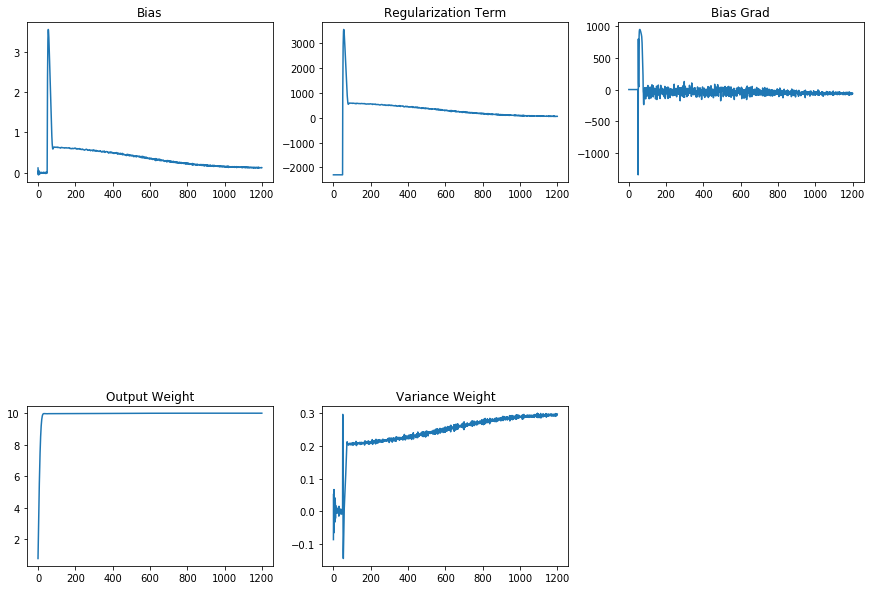

In [749]:
df = pd.read_csv("learned_variances_log.csv")
df

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(331)
ax.set_title('Bias')
ax.plot(df['b_2'])
ax = fig.add_subplot(332)
ax.set_title('Regularization Term')
ax.plot(df['reg'])
ax = fig.add_subplot(333)
ax.set_title('Bias Grad')
ax.plot(df['b_2_grad'])
ax = fig.add_subplot(337)
ax.set_title('Output Weight')
ax.plot(df['w1_2'])
ax = fig.add_subplot(338)
ax.set_title('Variance Weight')
ax.plot(df['w2_2'])
# plt.savefig(".png")


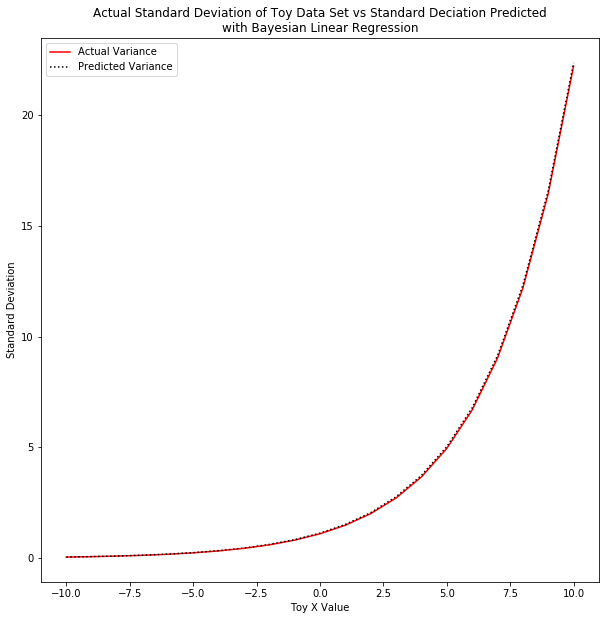

In [738]:
# W_s = np.array([0.0, 0.3]).reshape(-1, 1)
# print(W_s)
# b_s = 0.1

weights = bnn.model.l1.W_mu_DO.detach().numpy()
biases = bnn.model.l1.b_mu_O.detach().numpy()
variance_weight = weights[1][1]
bias = biases[1]
# sample_pred = bnn.model.forward(X_sample
                                

# predictions = bnn.model.forward(torch.Tensor(X_train))
# std_pred = torch.exp(predictions[:,1]).detach().numpy()

real_std = []
pred_std = []
for x in range(-10, 11):
    real_std.append(np.exp(0.3 * x + 0.1))
    pred_std.append(np.exp(variance_weight * x + bias ))
# print(real_std)
# fig, ax = plt.subplots(111, figsize=(10, 10))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('Actual Standard Deviation of Toy Data Set vs Standard Deciation Predicted\nwith Bayesian Linear Regression')
ax.plot(list(range(-10, 11)), real_std, label='Actual Variance', c='red')
ax.plot(list(range(-10, 11)), pred_std, linestyle='dotted', label='Predicted Variance', c='black')
ax.legend()
ax.set_ylabel("Standard Deviation")
ax.set_xlabel("Toy X Value")
# plt.savefig(".png")
fig.show()
# plt.plot(list(range(-10,11)), real_std, c='C3', label='real')
# plt.plot(std_pred, label='predicted')
# plt.title("Standard Deviation versus X value")

# plt.savefig("learned_variances.png")
# plt.xlim(right = 5

(5000,) (5000,)


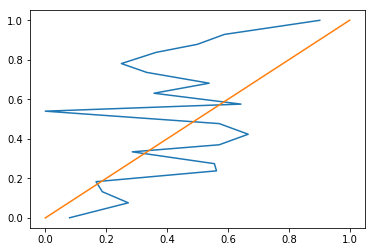

In [572]:
from sklearn.calibration import calibration_curve

n_bins = 20
calibration_mc_samples = 1000

sample_pred_list = []
for s in range(calibration_mc_samples):
    sample_pred = bnn.model(torch.tensor(X_train, dtype=torch.float), predict=True).detach().numpy()
    sample_pred_list.append(sample_pred)
    
# Each row is a sample, columns are datapoints; average across columns for probability
sample_preds = np.vstack(sample_pred_list).T
y_prob = np.mean(sample_preds, axis=1)
print(y_prob.shape, y_train.shape)
prob_true, prob_pred = calibration_curve(y_train, y_prob, n_bins=n_bins)

plt.plot(prob_true, prob_pred)
plt.plot([i/10 for i in range(0, 11)], [i /10 for i in range(0, 11)], c='black')
plt.title('Calibration plot')
plt.show()

torch.Size([150, 2])


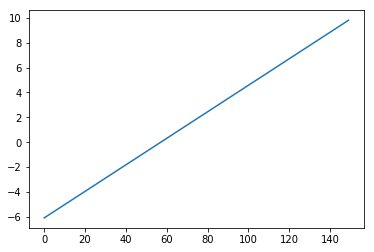

In [127]:
#X_sample = np.vstack([np.zeros(21), np.array(list(range(-10,11)))]).T

X_sample = np.arange(-5, 10, .1)
X_sample = torch.tensor(
                    np.vstack([np.zeros(len(X_sample)), X_sample]).T,
                    dtype=torch.float32)

print(X_sample.shape)


sample_pred = bnn.model.forward(X_sample).detach().numpy()


plt.plot(list(range(len(X_sample))),
         sample_pred[:,1])
plt.show()

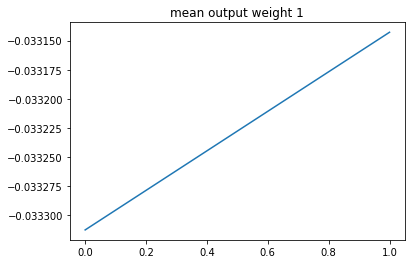

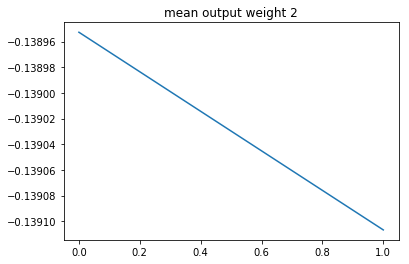

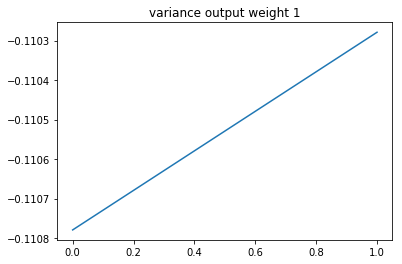

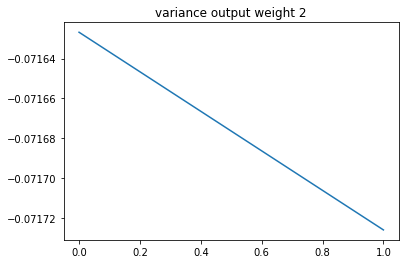

In [23]:
from graph_utils import *

df = pd.read_csv("1575743846.csv")


"""
w1_1,w1_2,w2_1,w2_2,
w1_1_grad,w1_2_grad,w2_1_grad,w2_2_grad,
b_1,b_2,
b_1_grad,b_2_grad
"""

graphCols(df, cols=['w1_1', 'w1_2', 'w2_1', 'w2_2'], ylabel='y', plotDim1=4, plotDim2=4)



In [ ]:
a = torch.normal(torch.tensor([0.0]*5), torch.tensor([5.0]*5))
print(a)

sig = nn.Sigmoid()
sig(a) > 0.5

bnn.likelihood_est(torch.tensor([0.0]*5), a, 0.1)

In [ ]:
for _ in range(10):
    pred1 = X_train @ W + b 
    pred2 = X_train @ W + b + np.random.normal(loc=0, scale=np.exp(X_train @ W_s + b_s))
    mae1 = np.mean(np.abs(pred1 - y_train))
    mae2 = np.mean(np.abs(pred2 - y_train))
    print("MAE 1: ", mae1, "MAE 2:", mae2)

In [ ]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

final_pred = bnn.model.forward(torch.Tensor(X_train))
print(final_pred[:5,0])


pred_std = torch.exp(final_pred[:,1])

print(pred_std)
print(X_train)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311, projection='3d')

sparse_cap = int(len(X_train) / 10)

ax.scatter(X_train[:sparse_cap,0], X_train[:sparse_cap,1], pred_std[:sparse_cap].detach().numpy())
ax.set_xlabel('X_train[:,0]')
ax.set_ylabel('X_train[:,1]')
ax.set_zlabel('output[:,1] (Standard Deviation)')



# 2D Plot:
ax_2d_x = fig.add_subplot(312)
ax_2d_x.scatter(X_train[:,0], pred_std.detach().numpy())
ax_2d_x.set_xlabel('X_train[:,0]')
ax_2d_x.set_ylabel('output[:,1] (Standard Deviation)')


ax_2d_y = fig.add_subplot(313)
ax_2d_y.scatter(X_train[:,1], pred_std.detach().numpy())
ax_2d_y.set_xlabel('X_train[:,1]')
ax_2d_y.set_ylabel('output[:,1] (Standard Deviation)')



In [ ]:
np.zeros(40)
X_sample = np.vstack([np.zeros(21), np.array(list(range(-10,11)))]).T
X_sample = torch.tensor(np.array(X_sample), dtype=torch.float32)


predictions = bnn.model.forward(torch.Tensor(X_train))

sample_pred = bnn.model.forward(X_sample)

y_pred = sample_pred[:,0].detach().numpy()
std_pred = torch.exp(sample_pred[:,1]).detach().numpy()
log_s_pred = sample_pred[:,1].detach().numpy()

print(std_pred)

# Sample variance to add to the y predictions
std_array = []
for scale in std_pred:
  std_array.append(np.random.normal(loc=0, scale=np.exp(scale)))
std_array = np.array((std_array))



"""
plt.scatter(X_train[:,0], y_pred + std_array, alpha=.1, label='predicted')
plt.scatter(X_train[:,0], y_train, alpha=.1, label='real')
plt.title("Y hat and Y values across X1")
plt.legend()
plt.savefig("x1_y.png")
"""


plt.show()

# For constant std dev#
#std_pred = 10 * torch.ones([y_pred.shape[0]], dtype=torch.float64)
# For constant std dev#

#plt.scatter(X_train[:,1], y_pred + std_array, alpha=.1, label='predicted')
#plt.scatter(X_sample[:,1], y_pred, alpha=.1, label='predicted')
plt.errorbar(X_sample[:,1], y_pred, yerr=(std_pred), fmt='o', label='predicted')
plt.scatter(X_train[:,1], y_train, alpha=.1, c='C1', label='real')
plt.ylabel("Y")
plt.xlabel("X")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.title("Predicted and real Y values vs X")
plt.legend()
plt.savefig("x_y1.png")
plt.show()



#stds = []
#Xs = list(range(-10, 11))
#for x in Xs:
#    stds.append(x + b_s)

#std_pred = predictions[:,1].detach().numpy()

real_std = []
for x in range(-10, 11):
    real_std.append(np.exp(np.array([0, x] @ W_s + b_s)))
print(real_std)
# plt.plot(list(range(-10,11)), list(range(0, 21)), c='C3', label='real')
plt.plot(list(range(-10,11)), real_std, c='C3', label='real')
plt.plot(X_sample[:,1], (std_pred), label='predicted')
plt.title("Standard Deviation versus X value")
plt.ylabel("standard deviation")
plt.xlabel("X")
plt.legend()
plt.savefig("std1.png")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.show()

In [ ]:
print(torch.exp(bnn.model.l1.W_log_s_DO))

In [ ]:

plt.plot([i for i in range(100)], loss_by_epoch)

In [ ]:
a = torch.tensor([3,3,3])
b = torch.tensor([5,5,3])
a == b